In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [89]:
dfShootings = pd.read_csv('datasets/shootings.csv')
usPop = pd.read_csv('datasets/acs2017_census_tract_data.csv')

Descobrimos a proporção da população de acordo com o censo 2017

In [90]:
usPop['Other'] = round(100 - usPop['Hispanic'] - usPop['White'] - usPop['Black'] - usPop['Native'] - usPop['Asian'], 2)
orderedRace = ['White','Black','Hispanic','Asian','Native','Other']

usRacePop = pd.DataFrame(columns = [])
arrayRacePop = []
mortalityPerMillion = []
usTotalPop = usPop['TotalPop'].sum()

for item in orderedRace:
    usRacePop[item + 'Pop'] = round(usPop[item] * usPop['TotalPop'] / 100)
    arrayRacePop.append(round(usRacePop[item+'Pop'].sum() / usTotalPop, 5))
    
arrayRacePop

[0.60808, 0.12158, 0.18474, 0.05237, 0.00647, 0.02677]

Descobrimos a proporção da amostra (o nosso dataset).

In [91]:
propSample = []
propSample = list(round(dfShootings['race'].value_counts() / len(dfShootings), 4))
propSample

[0.5058, 0.2652, 0.1843, 0.019, 0.0159, 0.0098]

Suspeitamos que a proporção de mortes por raça/etnia não é equivalente.

Text(0, 0.5, 'Grupo')

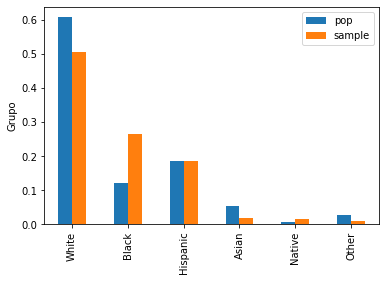

In [92]:
dfProp = pd.DataFrame(index=orderedRace)
dfProp['pop'] = arrayRacePop
dfProp['sample'] = propSample

dfProp.plot.bar()
plt.ylabel('Propopção')
plt.ylabel('Grupo')

# A) Hipótese Nula: A proporção de mortes por raça/etnia é equivalente

Nossa abordagem consiste em simular várias amostras da população e comparar com a amostra do nosso dataset, através do TVD.

In [93]:
def total_variation(p, q):
    return np.sum(np.abs(p - q)) / 2

originalTVD = total_variation(dfProp['pop'], dfProp['sample'])
originalTVD

0.15305499999999994

Criamos um DF que simula a população real, pegando as proporções de cada grupo no censo de 2017, calculado acima, com 5 pontos decimais de precisão.

In [94]:
print(arrayRacePop)
print(np.cumsum(arrayRacePop))

[0.60808, 0.12158, 0.18474, 0.05237, 0.00647, 0.02677]
[0.60808 0.72966 0.9144  0.96677 0.97324 1.00001]


In [95]:
popRace = []

for i in range(100000):
    popRace.append('White')
    if(i > 60807):
        popRace[i] = 'Black'
    if(i > 72965):
        popRace[i] = 'Hispanic'
    if(i > 91439):
        popRace[i] = 'Asian'
    if(i > 96676):
        popRace[i] = 'Native'
    if(i > 97323):
        popRace[i] = 'Other'

Agora temos um dataframe com 100000 habitantes que deveriam representar a população.<br>
Podemos checar se ele realmente representa a população contando os valores de cada grupo.

In [96]:
df = pd.DataFrame()
df['race'] = popRace

df['race'].value_counts()

White       60808
Hispanic    18474
Black       12158
Asian        5237
Other        2676
Native        647
Name: race, dtype: int64

Em geral, <b>sim!</b><br>

Para gerar uma amostra, fazemos um shuffle no dataframe e pegamos os primeiros N elementos.

In [97]:
def gera_amostra(df, n):
    np.random.shuffle(df.values)
    sample = df.iloc[0:n]
    
    sampleProp = []
    for idx in orderedRace:
        sampleProp.append(round((sample['race'] == idx).sum() / n, 4))
    return sampleProp

Geramos 5000 amostras de mesmo tamanho que o nosso dataset e calculamos a distância entre as proporções dos grupos amostrados e a proporção da população real.

In [84]:
#CUIDADO, PODE DEMORAR ALGUNS MINUTOS
N = len(dfShootings)
bN = 5000 #bootstrap N

A = []
for i in range(bN):
    A.append(gera_amostra(df, N))
A = np.array(A)
    
all_distances = []
for i in range(bN):
    all_distances.append(total_variation(arrayRacePop, A[i]))
all_distances = np.array(all_distances)

Calculamos um índice de confiança baseado na distribuição amostral gerada pelo bootstrap, a 95% de confiança, e plotamos o histograma.<br>
Calculamos o TVD entre a nossa amostra(dataset) e a proporção da população real.

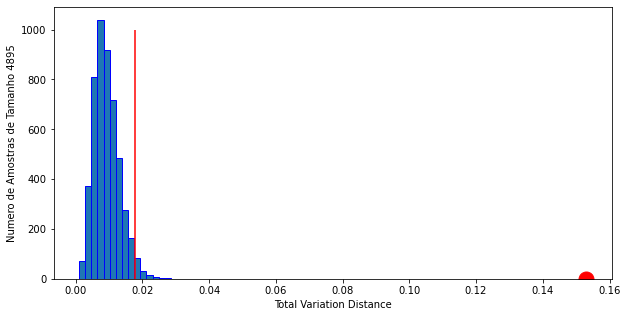

In [85]:
inferior, superior = np.percentile(all_distances, 2.5), np.percentile(all_distances, 97.5)
originalTVD = total_variation(dfProp['sample'], dfProp['pop'])

plt.figure(figsize=(10,5))

plt.hist(all_distances, bins=15, edgecolor='blue')
plt.ylabel('Numero de Amostras de Tamanho 4895')
plt.xlabel('Total Variation Distance')
plt.plot(originalTVD, [0], 'ro', ms=15)
plt.vlines(superior, 0, 1000, color='r')

plt.show()

O TVD observado está fora do intervalo de confiança calculado acima, ou seja, <b>temos evidência suficiente para rejeitar a hipótese nula.</b><br>
<h3> Podemos concluir então que a proporção de mortes por raça/etnia não é equivalente. </h3>

# B) Hipótese Nula: A proporção de mortes dos 25 estados com mais armas de fogo é igual a dos outros 25 estados

##### Ou seja, queremos testar se a população estar armada interfere ou não no número de mortes causadas pela polícia. Para isso, pesquisamos a ordem dos estados com mais armas por habitante e definimos a hipótese nula como "A proporção de morte dos 25 estados com mais armams de fogo é igual a dos outros 25 estados".

In [98]:
deathsArmedStates = dfShootings.groupby(['state']).size()
deathsArmedStates = pd.DataFrame(deathsArmedStates)
deathsArmedStates = deathsArmedStates.rename(columns = {0: 'Deaths'})
deathsArmedStates['APP'] = 0
deathsArmedStates.loc[['AK','AR','ID','WV','WY','MT','NM','AL','ND','HI','LA','SC','MS','KY','TN','NV','MN','TX','SD','WI','CO','IA','IN','FL','AZ'],'APP'] = 1
deathsArmedStates = deathsArmedStates.groupby(['APP']).sum()

#Filtrando a população dos 25 estados mais armados
statePop = usPop.groupby(['State']).sum()
statePop = statePop[['TotalPop']]
statePop['APP'] = 0
statePop.loc[['Alaska','Arkansas','Idaho','West Virginia','Wyoming','Montana','New Mexico','Alabama','North Dakota','Hawaii','Louisiana','South Carolina','Mississippi','Kentucky','Tennessee','Nevada','Minnesota','Texas','South Dakota','Wisconsin','Colorado','Iowa','Indiana','Florida','Arizona'],'APP'] = 1
selectStatePop = statePop.groupby(['APP']).sum()


#1º Linha: Estados MENOS armados; 2ª Linha: Estados MAIS armados
deathsArmedStates['StateCategory'] = ['25 Least Armed States', '25 Most Armed States']
deathsArmedStates['StatePop'] = selectStatePop['TotalPop']
deathsArmedStates['DeathsPerMilion'] = (deathsArmedStates['Deaths']/deathsArmedStates['StatePop'])*1000000
deathsArmedStates

,Deaths,StateCategory,StatePop,DeathsPerMilion
APP,,,,
0,2469,25 Least Armed States,198307811,12.450342
1,2426,25 Most Armed States,126165559,19.228703


In [99]:
t_obs = deathsArmedStates.loc[1]['DeathsPerMilion'] - deathsArmedStates.loc[0]['DeathsPerMilion']
t_obs

6.778360845941998

In [100]:
statePopRandom = statePop.copy()
N = 10000
diferencas = np.zeros(N)

for i in range(N):
    np.random.shuffle(statePopRandom['APP'].values)
    selectStateRandom = statePopRandom.groupby(['APP']).sum()
    
    deathsArmedStates['StatePop'] = selectStateRandom['TotalPop']
    deathsArmedStates['DeathsPerMilion'] = (deathsArmedStates['Deaths']/deathsArmedStates['StatePop'])*1000000
    
    diff = deathsArmedStates.loc[1]['DeathsPerMilion'] - deathsArmedStates.loc[0]['DeathsPerMilion']
    diferencas[i] = diff
diferencas

array([-1.3723207 , 10.00504813,  5.36711144, ..., -3.1738797 ,
        8.89409842,  3.59670112])

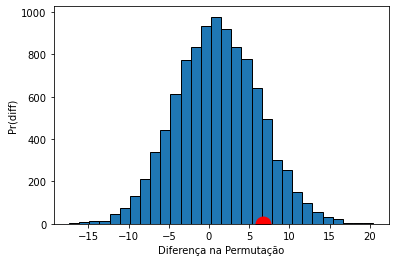

In [101]:
plt.hist(diferencas, bins=30, edgecolor='k')
plt.xlabel('Diferença na Permutação')
plt.ylabel('Pr(diff)')

plt.plot(t_obs, [0], 'ro', ms=15)

In [102]:
inferior, superior = np.percentile(diferencas, 2.5), np.percentile(diferencas, 97.5)
print("Intervalo de confiança: ", [inferior, superior])
print("Valor observado: ", t_obs)

Intervalo de confiança:  [-8.807732908760661, 11.312170123076376]
Valor observado:  6.778360845941998


<b>Não temos evidências para rejeitar a hipótese nula</b>, pois o valor observado (6.77) está dentro do intervalo de confiança (-9.08, 10.99). Isto é, caso a ordem de estados mais armados fosse aleatória, não haveria diferença estatística no número de mortes causadas por policiais nos Estados Unidos.<br>
<h3> Podemos concluir então que a proporção de mortes nos dois grupos de estados é igual.